# 多层感知机

## 从零开始的多层感知机

0.4300101200739543 0.8541666666666666


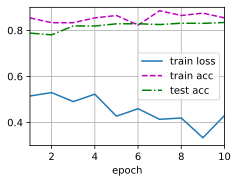

In [1]:
import torch
from IPython import display
from d2l import torch as d2l


class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]


class Softmax:

    def __init__(self, batch_size, num_inputs, num_outputs):
        self.batch_size = batch_size
        self.W = torch.normal(0, 0.01
                         , size=(num_inputs, num_outputs), requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def softmax(self, X):
        X_exp = torch.exp(X)
        partition = X_exp.sum(1, keepdim=True)
        return X_exp / partition
    
    def net(self, X):
        return self.softmax(torch.matmul(X.reshape((-1, self.W.shape[0])), self.W) + self.b)

    def cross_entropy(self, y_hat, y):
        return - torch.log(y_hat[range(len(y_hat)), y])
    
    @staticmethod
    def sgd(params, lr, batch_size):
        """Minibatch stochastic gradient descent.

        Defined in :numref:`sec_utils`"""
        with torch.no_grad():
            for param in params:
                param -= lr * param.grad / batch_size
                param.grad.zero_()

    def updater(self, batch_size, lr=0.1):
        return self.sgd([self.W, self.b], lr, batch_size)

    def accuracy(self, y_hat, y):
        """计算预测正确的数量"""
        if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
            y_hat = y_hat.argmax(axis=1)
        cmp = y_hat.type(y.dtype) == y
        return float(cmp.type(y.dtype).sum())

    def evaluate_accuracy(self, net, data_iter):
        """计算在指定数据集上模型的精度"""
        metric = Accumulator(2)
        with torch.no_grad():
            for X, y in data_iter:
                metric.add(self.accuracy(net(X), y), y.numel())
        return metric[0] / metric[1]

    def train_epoch(self, train_iter, net, loss, updater):
        metric = Accumulator(3)
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y)
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), self.accuracy(y_hat, y), y.numel())
        return metric[0] / metric[2], metric[1] / metric[2]

    def train(self, net, train_iter, test_iter, loss, num_epochs, updater):
        animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
        for epoch in range(num_epochs):
            train_metrics = self.train_epoch(train_iter, net, loss, updater)
            test_acc = self.evaluate_accuracy(net, test_iter)
            animator.add(epoch + 1, train_metrics + (test_acc,))
        train_loss, train_acc = train_metrics
        print(train_loss, train_acc)
        assert train_loss < 0.5, train_loss
        assert train_acc <= 1 and train_acc > 0.7, train_acc
        assert test_acc <= 1 and test_acc > 0.7, test_acc

    def main(self):
        train_iter, test_iter = d2l.load_data_fashion_mnist(self.batch_size)
        num_epochs = 10
        self.train(net=self.net, train_iter=train_iter, test_iter=test_iter, loss=self.cross_entropy, num_epochs=num_epochs, updater=self.updater)


if __name__ == '__main__':
    s = Softmax(batch_size=256, num_inputs=784, num_outputs=10)
    s.main()


代码拆解

In [1]:
# 初始化
import torch

batch_size=256
num_inputs=784
num_outputs=10

batch_size = batch_size
W = torch.normal(0, 0.01
                , size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [2]:
W.shape, W

(torch.Size([784, 10]),
 tensor([[ 0.0069,  0.0257, -0.0097,  ..., -0.0014, -0.0011,  0.0033],
         [ 0.0050, -0.0138, -0.0094,  ...,  0.0005,  0.0218,  0.0050],
         [ 0.0108, -0.0151, -0.0089,  ..., -0.0122,  0.0136,  0.0166],
         ...,
         [-0.0047, -0.0004,  0.0156,  ...,  0.0064,  0.0018, -0.0083],
         [-0.0027,  0.0113,  0.0096,  ...,  0.0059,  0.0061, -0.0105],
         [ 0.0119, -0.0125, -0.0115,  ...,  0.0080,  0.0210,  0.0049]],
        requires_grad=True))

In [3]:
l = [float(e) for e in W.flatten()]
max_l = max(l)
min_l = min(l)
max_l - min_l

0.07492221146821976

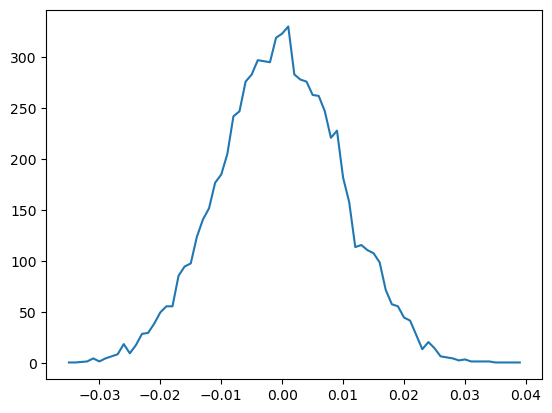

In [4]:
import math
import collections
import matplotlib.pyplot as plt

ndict = collections.defaultdict(int)
for e in l:
    ndict[math.floor(e*1000)/1000] += 1

nl = sorted(ndict.items(), key=lambda e: e[0])
plt.plot([e[0] for e in nl], [e[1] for e in nl])

In [5]:
b.shape, b

(torch.Size([10]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))

In [6]:
from d2l import torch as d2l

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [7]:
xx = [e for e in train_iter][:1]
type(xx[0]), len(xx[0])

(list, 2)

In [8]:
xx[0][0].shape, xx[0][1].shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [9]:
104491 + 96213, 256*28*28

(200704, 200704)

In [10]:
sum([1 for e in xx[0][0].flatten() if e != 0.0]), sum([1 for e in xx[0][0].flatten() if e == 0.0]), xx[0][0]

(96714,
 103990,
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.2078,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.1765,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0431,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
 

In [11]:
xx[0][1]

tensor([8, 1, 9, 2, 1, 2, 1, 2, 6, 8, 9, 7, 9, 2, 4, 7, 0, 4, 0, 8, 5, 3, 4, 4,
        0, 8, 3, 2, 9, 5, 1, 2, 2, 0, 2, 3, 6, 7, 7, 3, 3, 3, 2, 4, 3, 2, 4, 2,
        5, 4, 3, 0, 0, 2, 0, 9, 3, 6, 7, 4, 3, 3, 4, 5, 5, 4, 6, 3, 2, 5, 9, 9,
        0, 8, 3, 0, 4, 6, 6, 5, 5, 1, 9, 6, 4, 3, 0, 9, 8, 7, 3, 0, 7, 5, 5, 8,
        9, 5, 6, 5, 8, 7, 7, 8, 7, 5, 3, 4, 4, 9, 0, 2, 9, 5, 8, 1, 7, 8, 7, 9,
        1, 9, 3, 9, 0, 9, 2, 0, 1, 2, 2, 1, 5, 5, 4, 4, 6, 2, 5, 6, 9, 2, 2, 0,
        3, 9, 3, 2, 8, 8, 8, 8, 5, 5, 7, 9, 3, 5, 4, 2, 0, 2, 5, 6, 8, 5, 6, 7,
        3, 2, 7, 9, 9, 0, 6, 7, 9, 9, 5, 5, 3, 3, 3, 4, 2, 7, 7, 9, 1, 5, 8, 4,
        4, 2, 3, 4, 8, 7, 9, 3, 6, 6, 0, 0, 7, 0, 5, 4, 0, 8, 0, 3, 5, 0, 6, 0,
        6, 7, 9, 1, 5, 4, 8, 9, 7, 4, 9, 9, 0, 5, 0, 7, 5, 8, 8, 9, 1, 7, 9, 9,
        5, 5, 3, 3, 3, 0, 9, 9, 1, 8, 6, 9, 4, 0, 9, 3])

In [12]:
X_exp = torch.exp(xx[0][0][0])
X_exp.shape, X_exp

(torch.Size([1, 28, 28]),
 tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000, 1.0000, 1.0944, 1.6326, 1.5333, 1.5036, 1.5214,
           1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0039, 1.0000,
           1.0079, 1.0000, 1.3056, 1.8509, 1.0901, 1.0000, 1.0000, 1.1293,
           1.7728, 1.0359, 1.0000, 1.0079, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0158,
           1.0000, 1.3367, 1.7316, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
           1.0319, 1.8437, 1.0000, 1.0000, 1.0039, 1.0000, 1.0000, 1.0000,
           1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0158, 1.0000,
           1.2214, 1.7046, 1.0000, 1.0000, 1.0079, 1.0000, 1.0000, 1.0039,
           1.0000

In [13]:
partition = X_exp.sum(1, keepdim=True)
partition.shape, partition

(torch.Size([1, 1, 28]),
 tensor([[[28.0000, 28.0000, 34.7866, 42.9314, 39.1164, 40.2413, 42.2041,
           42.3271, 39.7966, 38.8316, 38.7785, 38.2433, 37.4894, 36.9938,
           37.8536, 37.9170, 38.4323, 38.8356, 37.9806, 40.6605, 41.0601,
           40.1875, 37.7689, 40.6407, 39.5785, 29.8341, 28.0000, 28.0000]]]))

In [14]:
rr = X_exp / partition
rr.shape, rr

(torch.Size([1, 28, 28]),
 tensor([[[0.0357, 0.0357, 0.0287, 0.0233, 0.0256, 0.0249, 0.0237, 0.0236,
           0.0251, 0.0258, 0.0258, 0.0286, 0.0435, 0.0414, 0.0397, 0.0401,
           0.0260, 0.0257, 0.0263, 0.0246, 0.0244, 0.0249, 0.0265, 0.0246,
           0.0253, 0.0335, 0.0357, 0.0357],
          [0.0357, 0.0357, 0.0287, 0.0233, 0.0256, 0.0249, 0.0238, 0.0236,
           0.0253, 0.0258, 0.0337, 0.0484, 0.0291, 0.0270, 0.0264, 0.0298,
           0.0461, 0.0267, 0.0263, 0.0248, 0.0244, 0.0249, 0.0265, 0.0246,
           0.0253, 0.0335, 0.0357, 0.0357],
          [0.0357, 0.0357, 0.0287, 0.0233, 0.0256, 0.0249, 0.0237, 0.0240,
           0.0251, 0.0344, 0.0447, 0.0261, 0.0267, 0.0270, 0.0264, 0.0264,
           0.0268, 0.0475, 0.0263, 0.0246, 0.0245, 0.0249, 0.0265, 0.0246,
           0.0253, 0.0335, 0.0357, 0.0357],
          [0.0357, 0.0357, 0.0287, 0.0233, 0.0256, 0.0249, 0.0241, 0.0236,
           0.0307, 0.0439, 0.0258, 0.0261, 0.0269, 0.0270, 0.0264, 0.0265,
           0.0260

In [15]:
sum(e[0] for e in rr[0]), sum(e[1] for e in rr[0])

(tensor(1.0000), tensor(1.0000))

In [16]:
sum(rr.flatten())

tensor(28.0000)

In [17]:
# def softmax(X):
#     X_exp = np.exp(X)
#     partition = X_exp.sum(1, keepdims=True)
#     return X_exp / partition  # 这里应用了广播机制

In [18]:
# import numpy as np

# X = np.random.normal(0, 1, (2, 5))
# X

In [19]:
# X_prob = softmax(X)
# X_prob, X_prob.sum(1)

In [20]:
y_hat = rr
y = 7

In [21]:
len(y_hat), range(len(y_hat))

(1, range(0, 1))

In [22]:
y_hat

tensor([[[0.0357, 0.0357, 0.0287, 0.0233, 0.0256, 0.0249, 0.0237, 0.0236,
          0.0251, 0.0258, 0.0258, 0.0286, 0.0435, 0.0414, 0.0397, 0.0401,
          0.0260, 0.0257, 0.0263, 0.0246, 0.0244, 0.0249, 0.0265, 0.0246,
          0.0253, 0.0335, 0.0357, 0.0357],
         [0.0357, 0.0357, 0.0287, 0.0233, 0.0256, 0.0249, 0.0238, 0.0236,
          0.0253, 0.0258, 0.0337, 0.0484, 0.0291, 0.0270, 0.0264, 0.0298,
          0.0461, 0.0267, 0.0263, 0.0248, 0.0244, 0.0249, 0.0265, 0.0246,
          0.0253, 0.0335, 0.0357, 0.0357],
         [0.0357, 0.0357, 0.0287, 0.0233, 0.0256, 0.0249, 0.0237, 0.0240,
          0.0251, 0.0344, 0.0447, 0.0261, 0.0267, 0.0270, 0.0264, 0.0264,
          0.0268, 0.0475, 0.0263, 0.0246, 0.0245, 0.0249, 0.0265, 0.0246,
          0.0253, 0.0335, 0.0357, 0.0357],
         [0.0357, 0.0357, 0.0287, 0.0233, 0.0256, 0.0249, 0.0241, 0.0236,
          0.0307, 0.0439, 0.0258, 0.0261, 0.0269, 0.0270, 0.0264, 0.0265,
          0.0260, 0.0286, 0.0465, 0.0246, 0.0244, 0.0250,

In [23]:
y_hat.shape, y_hat[range(len(y_hat)), y]

(torch.Size([1, 28, 28]),
 tensor([[0.0357, 0.0357, 0.0287, 0.0233, 0.0256, 0.0427, 0.0399, 0.0236, 0.0260,
          0.0258, 0.0258, 0.0261, 0.0267, 0.0270, 0.0264, 0.0264, 0.0260, 0.0257,
          0.0263, 0.0246, 0.0273, 0.0455, 0.0265, 0.0246, 0.0253, 0.0335, 0.0357,
          0.0357]]))

In [25]:
l = - torch.log(y_hat[range(len(y_hat)), y])
len(l[0]), l

(28,
 tensor([[3.3322, 3.3322, 3.5492, 3.7596, 3.6665, 3.1537, 3.2209, 3.7454, 3.6485,
          3.6592, 3.6579, 3.6440, 3.6241, 3.6108, 3.6337, 3.6354, 3.6489, 3.6593,
          3.6371, 3.7053, 3.6013, 3.0896, 3.6315, 3.7048, 3.6783, 3.3957, 3.3322,
          3.3322]]))

In [26]:
l.sum().backward()
updater(X.shape[0])

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## 多层感知机的简洁实现